In [96]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import special_ortho_group
from sklearn.cross_decomposition import CCA

rng = np.random.default_rng()

In [97]:
def random_sub_basis(m, n, rng=None):
    if m == 1:
        return np.array([[1]])[:,:n]
    return special_ortho_group(dim=m).rvs(random_state=rng)[:,:n]

# Generating Data

## FA
$$
\begin{gather}
z_i \sim \mathcal{N}(0,I)\\
x_i \sim \mathcal{N}(W z_i + \mu, D)
\end{gather}
$$

In [3]:
n_points = 100
high_d = 4
latent_d = 2

W = rng.random(size=(high_d, latent_d))
cov = np.diag(np.arange(high_d) + 1)

zs = []
xs = []
for _ in range(n_points):
    z = rng.multivariate_normal(np.zeros(latent_d), np.eye(latent_d))
    x = rng.multivariate_normal(W @ z, cov)
    zs.append(z)
    xs.append(x)

## Multi-space CCA

In [4]:
def generate_pcca(n_points = 100, x_d = 2, y_d = 2, shared_latent_d = 1, x_latent_d = 0, y_latent_d = 0, cov_scaler = .1, rng=rng):
    B_x = random_sub_basis(x_d, x_latent_d, rng=rng)
    W_x = random_sub_basis(x_d, shared_latent_d, rng=rng)
    B_y = random_sub_basis(y_d, y_latent_d, rng=rng)
    W_y = random_sub_basis(y_d, shared_latent_d, rng=rng)
    
    # cov_x = np.diag(np.arange(x_d) + 1) * cov_scaler
    # cov_y = np.diag(np.arange(y_d) + 1) * cov_scaler
    cov_x = np.eye(x_d) * cov_scaler
    cov_y = np.eye(y_d) * cov_scaler
    
    xs = []
    ys = []
    for _ in range(n_points):
        z_shared = rng.multivariate_normal(np.zeros(shared_latent_d), np.eye(shared_latent_d)) if shared_latent_d > 0 else []
        z_x = rng.multivariate_normal(np.zeros(x_latent_d), np.eye(x_latent_d)) if x_latent_d > 0 else []
        z_y = rng.multivariate_normal(np.zeros(y_latent_d), np.eye(y_latent_d)) if y_latent_d > 0 else []
        x = rng.multivariate_normal(B_x @ z_x + W_x @ z_shared, cov_x)
        y = rng.multivariate_normal(B_y @ z_y + W_y @ z_shared, cov_y)
        ys.append(y)
        xs.append(x)
    return np.array(xs), np.array(ys), dict(W_x=W_x, W_y=W_y, cov_x=cov_x, cov_y=cov_y)

### Plotting

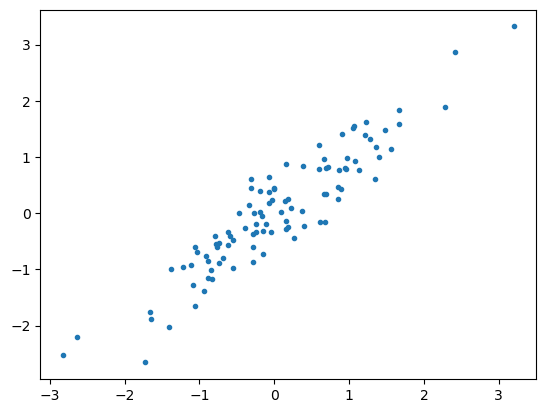

In [5]:
xs, ys, _ = generate_pcca(x_d=1, y_d=1, cov_scaler=.1)
for i in range(n_points):
    plt.plot(xs[i], ys[i], '.', color='C0')

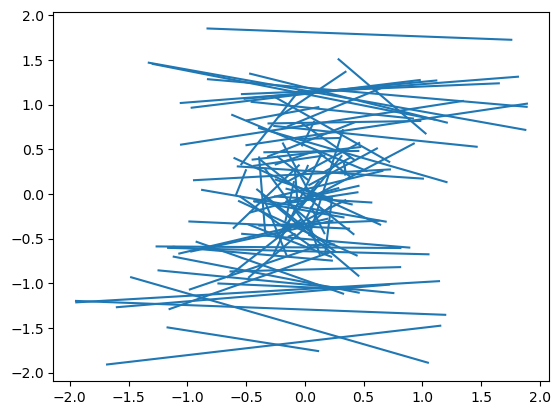

In [6]:
xs, ys, _ = generate_pcca()
for i in range(n_points):
    plt.plot(xs[i], ys[i], color='C0')

# Inference

## CCA- direct

In [72]:
def calc_cov(a, b):
    dma = a - a.mean(axis=0)
    dmb = b - b.mean(axis=0)
    return 1/(a.shape[0] - 1) *  (dma.T @ dmb)

t = np.linspace(0,2*np.pi, 100)
circle_points = np.column_stack([np.cos(t), np.sin(t)]).T

In [86]:
x_d = 2
y_d = 2
xs, ys, hidden_vars = generate_pcca(x_d=x_d, y_d=y_d, cov_scaler=.1)
xs -= xs.mean(axis=0)
ys -= ys.mean(axis=0)

In [93]:
sigma_x_hat = calc_cov(xs, xs)
sigma_y_hat = calc_cov(ys, ys)
sigma_xy_hat = calc_cov(xs, ys)
sigma_yx_hat = calc_cov(ys, xs)

mat_1 = np.block([
    [np.linalg.pinv(sigma_x_hat), np.zeros((x_d, y_d))       ], 
    [np.zeros((y_d, x_d)),        np.linalg.pinv(sigma_y_hat)]
])
mat_2 = np.block([
    [np.zeros((x_d, x_d)), sigma_xy_hat         ], 
    [sigma_yx_hat,         np.zeros((y_d, y_d)),]
])

evals, evecs = np.linalg.eig(mat_1 @ mat_2)
idx = np.argmax(np.abs(evals))
x_v = evecs[:x_d,idx]
# x_v /= np.linalg.norm(x_v)
y_v = evecs[:y_d,idx]
# y_v /= np.linalg.norm(y_v)

In [92]:
cca = CCA(n_components=1).fit(xs,ys)
x_v = cca.x_loadings_[:,0]
y_v = cca.y_loadings_[:,0]

In [89]:
cca.x_loadings_

array([[0.80011249],
       [0.7219695 ]])

In [90]:
cca.x_rotations_

array([[0.93866039],
       [0.34484296]])

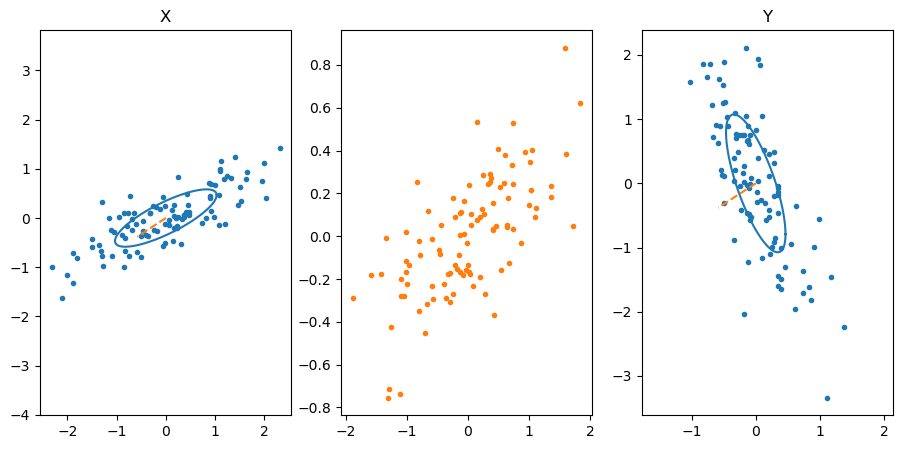

In [94]:
fig, axs = plt.subplots(nrows=1,ncols=3, figsize=(11,5))
axs[0].plot(xs[:,0], xs[:,1], '.')
ellipse_points = (np.linalg.cholesky(sigma_x_hat) @ circle_points).T + xs.mean(axis=0)
axs[0].plot(ellipse_points[:,0], ellipse_points[:,1], color="C0")
axs[0].plot([0, x_v[0]], [0, x_v[1]], '--')
# axs[0].plot([0, hidden_vars['W_x'][0,0]], [0, hidden_vars['W_x'][1,0]], '-', color='C1', alpha=.5)
axs[0].axis("equal")
axs[0].set_title("X")

axs[2].plot(ys[:,0], ys[:,1], '.')
ellipse_points = (np.linalg.cholesky(sigma_y_hat) @ circle_points).T + ys.mean(axis=0)
axs[2].plot(ellipse_points[:,0], ellipse_points[:,1], color="C0")
axs[2].plot([0, y_v[0]], [0, y_v[1]], '--')
# axs[2].plot([0, hidden_vars['W_y'][0,0]], [0, hidden_vars['W_y'][1,0]], '-', color='C1', alpha=.5)
axs[2].axis("equal")
axs[2].set_title("Y")

axs[1].plot(xs @ x_v, ys@y_v, '.', color="C1");

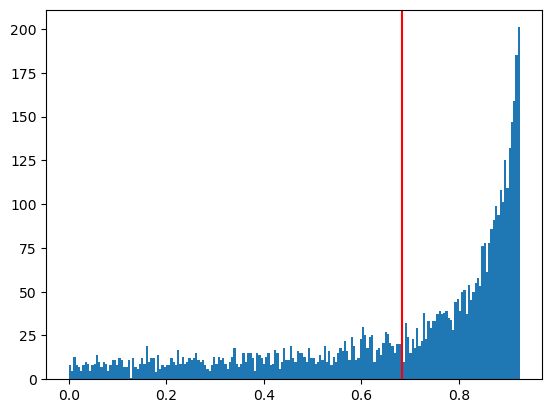

In [95]:
rs = []
for i in range(5000):
    candidate_x_v = np.squeeze(random_sub_basis(xs.shape[1], 1))
    candidate_y_v = np.squeeze(random_sub_basis(ys.shape[1], 1))
    r = np.corrcoef(xs @ candidate_x_v, ys @ candidate_y_v)[0,1]
    rs.append(np.abs(r))
    

plt.axvline(np.abs(np.corrcoef(xs @ x_v, ys @ y_v)[0,1]), color='red')
plt.hist(rs, bins=200);

* [background](https://gregorygundersen.com/blog/2018/07/17/cca/)
* [iterative](https://doi.org/10.3390/app10217827)

* [projection pursuit](https://en.wikipedia.org/wiki/Projection_pursuit)